In [37]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import re
import datetime
import os

In [38]:
"""
TODO:
- clean up code
- adapt functions to classification
- save figures into directory
- cdf tempo entre analises
  - ignorar todos menores que 20 min
"""

'\nTODO:\n- clean up code\n- adapt functions to classification\n- save figures into directory\n- cdf tempo entre analises\n  - ignorar todos menores que 20 min\n'

### Import

In [39]:
def load_data(dir_path):
    """Load data from pickle files
    
    Keyword arguments:
    file_path -- path to pickle files
    Return: dicts for each file
    """
    
    with open(dir_path + "output_data_features_class", "rb") as f:
        features_class = pkl.load(f)
    with open(dir_path + "output_data_features_num", "rb") as f:
        features_num = pkl.load(f)
    with open(dir_path + "output_data_votes_class", "rb") as f:
        votes_class = pkl.load(f)
    with open(dir_path + "output_data_votes_num", "rb") as f:
        votes_num = pkl.load(f)
        
    return features_class, features_num, votes_class, votes_num 
    
    

In [40]:
team = {
  "Admin": "admin@defectdojo.local",
  "Bernnardo Seraphim": "bernnardosbo@gmail.com",
  "Francisco Aragão": "franciscoaragao785@gmail.com",
  "Iago Rios": "isrios89@gmail.com",
  "Italo Cunha": "italocunha@gmail.com",
  "Leonardo Maia": "leonardooliveiramaia1@gmail.com",
  "Matheus Gimpel": "matheus.gimpel@gmail.com",
  "Gabriel Pains": "painsgabriel@gmail.com",
  "Thiago Souza": "thbragasouza@gmail.com"
}

In [41]:

df_team = pd.DataFrame(list(team.items()), columns=["Nome", "email"])
df_team["role"] = "team"
df_team


df_team.to_csv("../../data/team.csv", columns=["Nome", "email"], index=False)

In [42]:
fc, fn, vc, vn = load_data("../../data/")
with open("../../data/kev.json", "r") as f:
    kev = json.load(f)['vulnerabilities']
kev_set = {i["cveID"] for i in kev}
with open("../../data/users.json", "r") as f:
  users = json.load(f)
  
df_interns = pd.read_csv("../../data/interns.csv", names=["Nome", "email",  "team", "project"])
df_mentors = pd.read_csv("../../data/mentors.csv", names=["Nome", "email",  "team"])
df_interns["role"] = "intern"
df_mentors["role"] = "mentor"

df_interns = df_interns[["Nome", "email", "role"]]
df_mentors = df_mentors[["Nome", "email", "role"]]
df_users = pd.concat([df_interns, df_mentors, df_team], axis=0).copy().reset_index(drop=True)
df_users = df_users.astype({"Nome": "string", "email": "string", "role": "string"})

cat_users = users["crivo"]
num_users = users["crivo-num"]
dev_users = users["crivo-dev"]

In [43]:
cat_users = users["crivo"]
cat_users = {str(v): k for k, v in cat_users.items()}
cat_users_df = pd.DataFrame(list(zip(cat_users.keys(), cat_users.values())), columns=["email", "user_id"]).convert_dtypes()
cat_users_df = cat_users_df.merge(df_users, on="email", how="left")
cat_users_df = cat_users_df[["user_id", "Nome", "email", "role" ]]
cat_users_df = cat_users_df.astype({"user_id": "int64", "email": "string", "role": "string"})
cat_users_df.head(3)

,user_id,Nome,email,role
0,20,Eddy Martins,Eddymartinsdias@hotmail.com,mentor
1,1,Admin,admin@defectdojo.local,team
2,13,Alonso Dos Santos Silva,alonsosatos4@gmail.com,intern


In [44]:
num_users = users["crivo-num"]
num_users = {str(v): k for k, v in num_users.items()}
num_users_df = pd.DataFrame(list(zip(num_users.keys(), num_users.values())), columns=["email", "user_id"]).convert_dtypes()
num_users_df = num_users_df.merge(df_users, on="email", how="left")
num_users_df = num_users_df[["user_id", "Nome", "email", "role" ]]
num_users_df = num_users_df.astype({"user_id": "int64", "Nome": "string", "email": "string", "role": "string"})
num_users_df.head(3)

,user_id,Nome,email,role
0,1,Admin,admin@defectdojo.local,team
1,23,Alexandre Mundim de Oliveira,alessandro.fonseca@ebserh.gov.br,mentor
2,26,Alison Carmo Arantes,alexandremundimdeoliveira@gmail.com,mentor


### Exploratory Data Analysis

In [45]:
def get_cvelist(text):
    pattern = r"^\*\*CVEs\*\*: (.*)$"
    match = re.search(pattern, text, re.MULTILINE)
    if match:
        cve_list = match.group(1).split(', ')
        if cve_list == ['']:
            return None
        else:   
            return list(set(cve_list))
    else:
        return None

In [46]:
IN_KEV = 1
HAS_CVE = 2
NO_CVE = 3

def process_finding_df(iter):
  df = pd.DataFrame(iter)
  df = df[["id","title","description"]]
  df["id"] = df["id"] - 1
  df["cves"] = df["description"].apply(get_cvelist)
  df["class"] = df["cves"].apply(lambda cve_list: NO_CVE if not cve_list else IN_KEV if any(cve in kev_set for cve in cve_list) else HAS_CVE)
  return df

df_fn = process_finding_df(fn)
df_fc = process_finding_df(fc)

In [47]:
df_fn.head(2)

,id,title,description,cves,class
0,20,'/.//WEB-INF/' Information Disclosure Vulnerab...,**Name**: '/.//WEB-INF/' Information Disclosur...,[CVE-2021-41381],2
1,0,Check for Discard Service (TCP)_153.94.175.79_...,**Name**: Check for discard Service (TCP)\n**H...,[CVE-1999-0636],2


In [48]:
df_fc.head(2)

,id,title,description,cves,class
0,20,'/.//WEB-INF/' Information Disclosure Vulnerab...,**Name**: '/.//WEB-INF/' Information Disclosur...,[CVE-2021-41381],2
1,0,Apache HTTP Server End of Life (EOL) Detection...,**Name**: Apache HTTP Server End of Life (EOL)...,None,3


In [49]:
# NUMERIC VOTES
df_vn = pd.DataFrame(vn)

# Converting column to numeric
df_vn["vote_num"] = pd.to_numeric(df_vn["vote_num"])

# Renaming ambiguous columns
df_vn = df_vn.rename(columns={"id": "finding_id", "vote_num": "vote"})

# 0-based indexing for findings
df_vn["finding_id"] = df_vn["finding_id"] - 1

# Adding finding class between IN_KEV, HAS_CVE & NO_CVE
df_vn["finding_class"] = df_vn.join(df_fn.set_index("id"), on="finding_id")["class"]

# Converting timestamp to pandas datetime
df_vn["timestamp"] = pd.to_datetime(df_vn["timestamp"], format="ISO8601")

# Setting up avg related metrics
df_vn["avg"] = df_vn["finding_id"].map(df_vn.groupby("finding_id").agg({"vote": "mean"})["vote"])
df_vn["avg_error"] = abs(df_vn["vote"] - df_vn["avg"])

# Setting up title variable
df_vn["finding_title"] = pd.merge(df_vn, df_fn[["id", "title"]], left_on="finding_id", right_on="id")['title']


# Setting up variance related metrics
df_vn["var"] = df_vn["finding_id"].map(df_vn.groupby("finding_id").agg({"vote": "var"})["vote"])
df_vn["var_percentile"] = df_vn["finding_id"].map(df_vn.groupby("finding_id").agg({"vote": "var"})["vote"].rank(pct=True))

df_vn.head(10)

,finding_id,user_id,vote,timestamp,finding_class,avg,avg_error,finding_title,var,var_percentile
0,0,5,10,2025-04-27 21:48:59.950631+00:00,2,5.714286,4.285714,Check for Discard Service (TCP)_153.94.175.79_...,7.904762,1.000000
1,0,10,6,2025-04-29 22:05:19.193009+00:00,2,5.714286,0.285714,Check for Discard Service (TCP)_153.94.175.79_...,7.904762,1.000000
2,0,12,1,2025-04-28 17:49:12.736380+00:00,2,5.714286,4.714286,Check for Discard Service (TCP)_153.94.175.79_...,7.904762,1.000000
3,0,13,4,2025-04-29 00:13:26.237885+00:00,2,5.714286,1.714286,Check for Discard Service (TCP)_153.94.175.79_...,7.904762,1.000000
4,0,14,5,2025-04-28 19:39:14.983384+00:00,2,5.714286,0.714286,Check for Discard Service (TCP)_153.94.175.79_...,7.904762,1.000000
5,0,16,7,2025-04-28 18:38:42.845653+00:00,2,5.714286,1.285714,Check for Discard Service (TCP)_153.94.175.79_...,7.904762,1.000000
6,0,18,7,2025-04-29 03:36:28.852695+00:00,2,5.714286,1.285714,Check for Discard Service (TCP)_153.94.175.79_...,7.904762,1.000000
7,1,5,10,2025-04-27 21:49:01.751120+00:00,1,9.714286,0.285714,"GitLab < 13.8.8, 13.9.x < 13.9.6, 13.10.x < 13...",0.238095,0.032258
8,1,10,9,2025-04-29 22:39:58.711813+00:00,1,9.714286,0.714286,"GitLab < 13.8.8, 13.9.x < 13.9.6, 13.10.x < 13...",0.238095,0.032258
9,1,12,10,2025-04-28 18:02:59.186738+00:00,1,9.714286,0.285714,"GitLab < 13.8.8, 13.9.x < 13.9.6, 13.10.x < 13...",0.238095,0.032258


In [50]:
# CLASS VOTES
df_vc = pd.DataFrame(vc)

# Converting classes to numeric
class_map = {class_name: index+1 for index, class_name in enumerate(df_vc["vote_class"].unique())}
df_vc["vote_class"] = df_vc["vote_class"].map(class_map)

# Renaming ambiguous columns
df_vc = df_vc.rename(columns={"id": "finding_id", "vote_class": "vote"})

# 0-based indexing for findings
df_vc["finding_id"] = df_vc["finding_id"] - 1

# Adding finding class between IN_KEV, HAS_CVE & NO_CVE
df_vc["finding_class"] = df_vc.join(df_fc.set_index("id"), on="finding_id")["class"]

# Converting timestamp to pandas datetime
df_vc["timestamp"] = pd.to_datetime(df_vc["timestamp"], format="ISO8601")

# Setting up avg related metrics
df_vc["avg"] = df_vc["finding_id"].map(df_vc.groupby("finding_id").agg({"vote": "mean"})["vote"])
df_vc["avg_error"] = abs(df_vc["vote"] - df_vc["avg"])

# Setting up title variable
df_vc["finding_title"] = pd.merge(df_vc, df_fc[["id", "title"]], left_on="finding_id", right_on="id")["title"]

# Setting up variance related metrics
df_vc["var"] = df_vc["finding_id"].map(df_vc.groupby(by="finding_id").agg({"vote": "mean"})["vote"])
df_vc["var_percentile"] = df_vc["finding_id"].map(df_vc.groupby("finding_id").agg({"vote": "var"})["vote"].rank(pct=True))

df_vc.head(10)

,finding_id,user_id,vote,timestamp,finding_class,avg,avg_error,finding_title,var,var_percentile
0,0,6,1,2025-04-27 21:26:52.848233+00:00,3,1.857143,0.857143,Apache HTTP Server End of Life (EOL) Detection...,1.857143,0.129032
1,0,10,2,2025-04-28 19:49:33.566692+00:00,3,1.857143,0.142857,Apache HTTP Server End of Life (EOL) Detection...,1.857143,0.129032
2,0,11,2,2025-04-29 13:17:18.457005+00:00,3,1.857143,0.142857,Apache HTTP Server End of Life (EOL) Detection...,1.857143,0.129032
3,0,12,2,2025-04-30 01:05:39.215489+00:00,3,1.857143,0.142857,Apache HTTP Server End of Life (EOL) Detection...,1.857143,0.129032
4,0,13,2,2025-04-29 02:42:00.741533+00:00,3,1.857143,0.142857,Apache HTTP Server End of Life (EOL) Detection...,1.857143,0.129032
5,0,14,2,2025-04-29 12:46:28.339912+00:00,3,1.857143,0.142857,Apache HTTP Server End of Life (EOL) Detection...,1.857143,0.129032
6,0,15,2,2025-04-28 16:25:11.683296+00:00,3,1.857143,0.142857,Apache HTTP Server End of Life (EOL) Detection...,1.857143,0.129032
7,1,6,3,2025-04-27 22:14:00.177641+00:00,1,2.142857,0.857143,"PHP < 5.3.13, 5.4.x < 5.4.3 Multiple Vulnerabi...",2.142857,0.161290
8,1,10,2,2025-04-28 19:58:24.103543+00:00,1,2.142857,0.142857,"PHP < 5.3.13, 5.4.x < 5.4.3 Multiple Vulnerabi...",2.142857,0.161290
9,1,11,2,2025-04-29 20:26:51.254562+00:00,1,2.142857,0.142857,"PHP < 5.3.13, 5.4.x < 5.4.3 Multiple Vulnerabi...",2.142857,0.161290


In [ ]:

def plot_votes_vs_mean(user, votes_user: pd.DataFrame, categorical=False, filename="default"):
  
    x = np.array(votes_user["avg"])
    y = np.array(votes_user["vote"])
    a, b = np.polyfit(x, y, 1)    
  
    y_hat = a * x + b
    y_mean = np.mean(y)
    
    ss_res = np.sum((y - y_hat)**2)
    ss_tot = np.sum((y - y_mean)**2)
    r2 = 1 - (ss_res / ss_tot)
    

    if categorical:
      plot_x = np.array([-0.5, 4])
      plot_y = a * plot_x + b
      plt.figure(figsize=(9, 6))
      # todo-> change shapes 
      plt.scatter(votes_user[votes_user["finding_class"] == IN_KEV]["avg"], votes_user[votes_user["finding_class"] == IN_KEV]["vote"], color="coral", label="Vulnerabilidades no KEV (com CVEs)", marker="v")
      plt.scatter(votes_user[votes_user["finding_class"] == HAS_CVE]["avg"], votes_user[votes_user["finding_class"] == HAS_CVE]["vote"], color="yellowgreen", label="Vulnerabilidades com CVEs", marker="o")
      plt.scatter(votes_user[votes_user["finding_class"] == NO_CVE]["avg"], votes_user[votes_user["finding_class"] == NO_CVE]["vote"], color="cornflowerblue", label="Vulnerabilidades sem CVEs", marker="s")
      plt.plot(plot_x, plot_y, color="red", label=f"Regressão Linear\nR2: {r2:.2f}")
      plt.legend()
      plt.grid(True, linestyle=":", linewidth=0.5, color='black', alpha=0.2)
      plt.title(f"Votos do Usuário vs Média de Votos")
      plt.xlim(0.8,4.2)
      plt.ylim(0.8,4.2)
      plt.yticks([1.375, 2.125, 2.875, 3.625], [ "Mild", "Moderate", "Severe", "Critical"])
      plt.xticks([1.375, 2.125, 2.875, 3.625], [ "Mild", "Moderate", "Severe", "Critical"])
      plt.ylabel("user Votes")
      plt.xlabel("Mean Votes")
      
      categorical_dir = "../../data/votebymean/categorical/"
      if not os.path.exists(categorical_dir):
        os.makedirs(categorical_dir)
      
      plt.savefig(f"{categorical_dir}{filename}.png")
        
    else:

      plot_x = np.array([-1, 10])
      plot_y = a * plot_x + b
      plt.figure(figsize=(9, 6))
      # todo-> change shapes 
      plt.scatter(votes_user[votes_user["finding_class"] == IN_KEV]["avg"], votes_user[votes_user["finding_class"] == IN_KEV]["vote"], color="coral", label="Vulnerabilidades no KEV (com CVEs)", marker="v")
      plt.scatter(votes_user[votes_user["finding_class"] == HAS_CVE]["avg"], votes_user[votes_user["finding_class"] == HAS_CVE]["vote"], color="yellowgreen", label="Vulnerabilidades com CVEs", marker="o")
      plt.scatter(votes_user[votes_user["finding_class"] == NO_CVE]["avg"], votes_user[votes_user["finding_class"] == NO_CVE]["vote"], color="cornflowerblue", label="Vulnerabilidades sem CVEs", marker="s")
      plt.plot(plot_x, plot_y, color="red", label=f"Regressão Linear\nR2: {r2:.2f}")
      plt.legend()
      plt.grid(True, linestyle=":", linewidth=0.5, color='black', alpha=0.2)
      plt.title(f"Votos do Usuário vs Média de Votos")
      plt.xlim(-1,11)
      plt.ylim(-1,11)
      plt.yticks(np.arange(0, 11, 1))
      plt.xticks(np.arange(0, 11, 1))
      plt.ylabel("user Votes")
      plt.xlabel("Mean Votes")
      
      
      numerical_dir = "../../data/votebymean/numerical/"
      if not os.path.exists(numerical_dir):
        os.makedirs(numerical_dir)
      
      plt.savefig(f"{numerical_dir}{filename}.png")
        
    
def plot_rank_error_time_series(intern, votes_intern, x_ticks=False):
    votes_intern.sort_values(by="timestamp", ascending=True, inplace=True)

    plt.figure(figsize=(12, 8))
    plt.scatter(votes_intern["timestamp"], votes_intern["avg_error"])

    plt.ylim(-0.5, 11)
    plt.yticks(np.arange(0, 11, 1))
    plt.ylabel("Erro absoluto em relação a média")
    plt.grid(True, linestyle=":", linewidth=0.5, color='black', alpha=0.2)
    plt.title("Série temporal do erro em relação ao valor médio do voto")

    if x_ticks:
        delta_timestamp = votes_intern["timestamp"].max() - votes_intern["timestamp"].min()

        if delta_timestamp < datetime.timedelta(minutes=1):
          plt.gca().xaxis.set_major_locator(mdates.SecondLocator(bysecond=range(0, 60, 2)))
          plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H:%M:%S"))
        elif delta_timestamp < datetime.timedelta(hours=0.5):
          plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
          plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H:%M:%S"))
        elif delta_timestamp < datetime.timedelta(hours=1):
          plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
          plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H:%M:%S"))
        elif delta_timestamp < datetime.timedelta(hours=3):
          plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
          plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H:%M:%S"))
        elif delta_timestamp < datetime.timedelta(hours=6):
          plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
          plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H:%M:%S"))
        elif delta_timestamp < datetime.timedelta(days=1):
          plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
          plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H:%M"))
        elif delta_timestamp < datetime.timedelta(days=7):
          plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
          plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
    else:
        plt.gca().xaxis.set_ticks([])

        plt.xlabel("Tempo")
    plt.savefig(f"../../data/vote_error_timeseries/{intern}.png", )
    
def generate_html_data(user, df_user, categorical=False):
    top3_highest_diff = df_user.sort_values(by="avg_error", ascending=False).iloc[:3]
    top3_highest_diff = top3_highest_diff[["finding_id", "avg", "vote", "avg_error", "var", "finding_title", "var_percentile"]].rename(columns={"finding_id": "id", "avg": "avg_rank", "vote": "user_rank", "finding_title": "title"})
    # round values
    top3_highest_diff["avg_rank"] = top3_highest_diff["avg_rank"].round(2)
    top3_highest_diff["user_rank"] = top3_highest_diff["user_rank"].round(2)
    top3_highest_diff["avg_error"] = top3_highest_diff["avg_error"].round(2)
    top3_highest_diff["var_percentile"] = top3_highest_diff["var_percentile"].round(2) * 100
    top3_highest_diff["title"] = top3_highest_diff["title"].astype("string")
  
  
    hightlight_vuln = top3_highest_diff.to_dict('records')

    final_vulns = []
    for vuln in hightlight_vuln:
      if vuln["avg_rank"] + vuln["var"]**0.5 <= vuln["user_rank"]:
        final_vulns.append(vuln)

    user_name = num_users_df[num_users_df["user_id"] == user]["Nome"].values[0]
    user_name = user_name.split()[0]
  
    html_data = {
    "intern_name": user_name,
    "highlight_vuln": final_vulns,
    "is_empty": False,
    "is_categorical": categorical
  }
    
    return html_data

In [52]:
from email_generator import generate_html

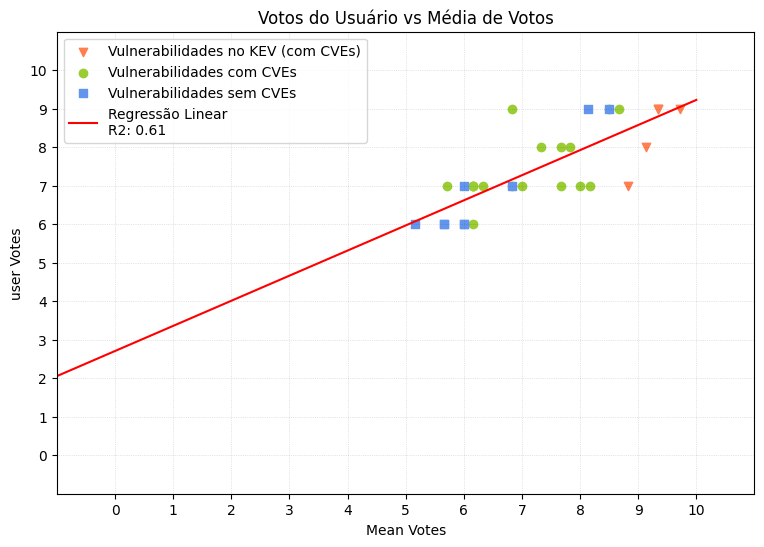

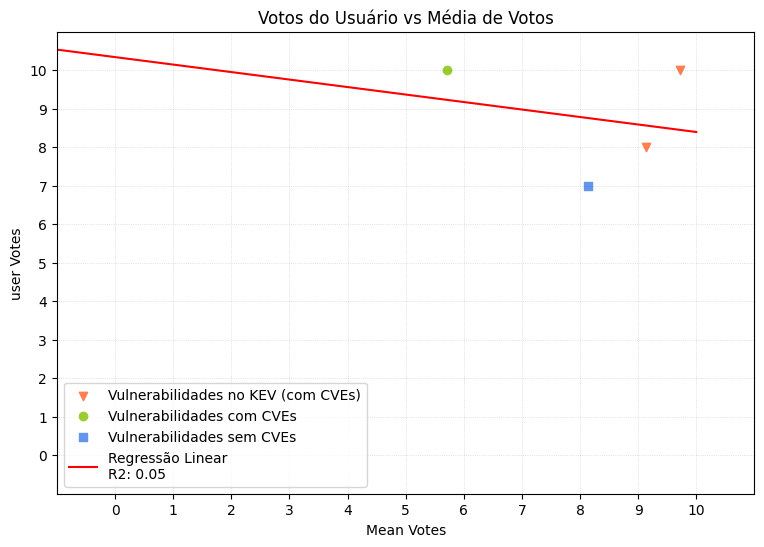

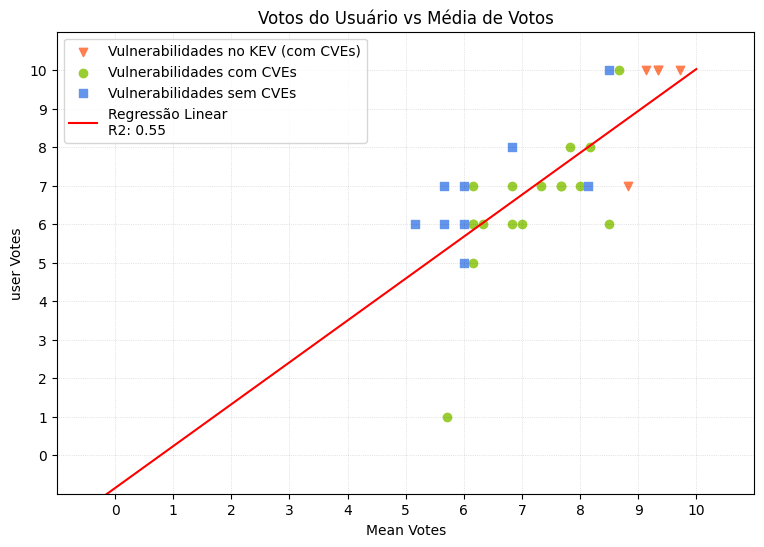

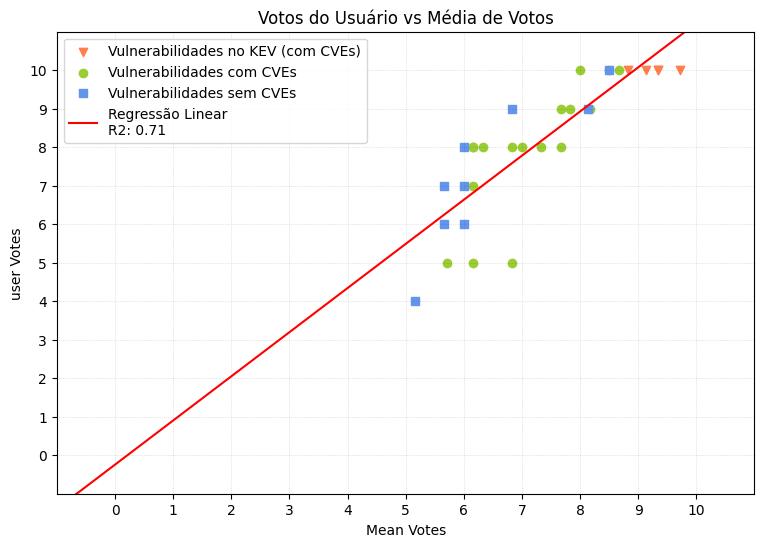

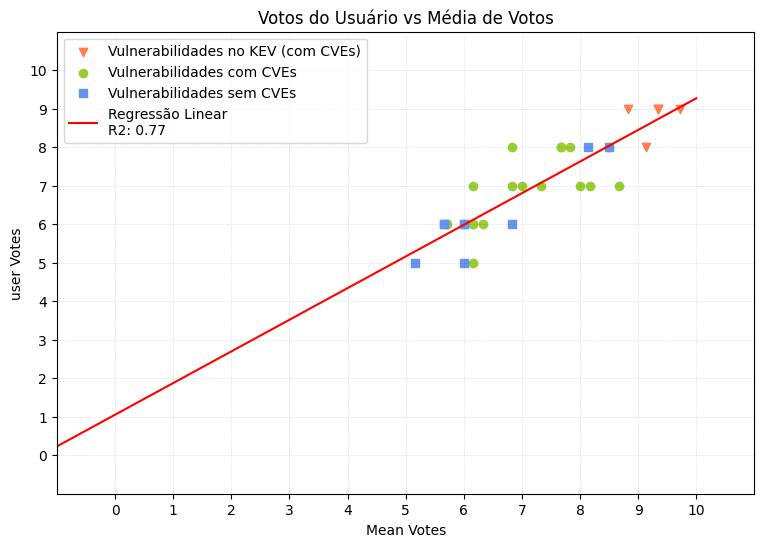

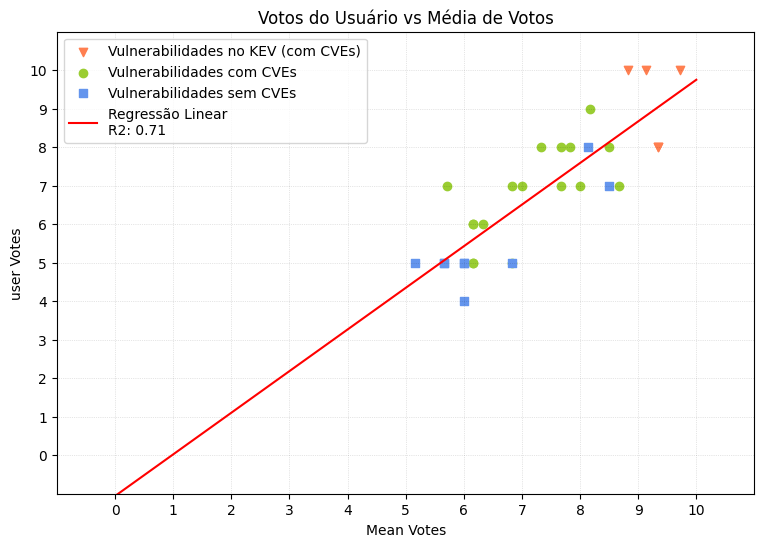

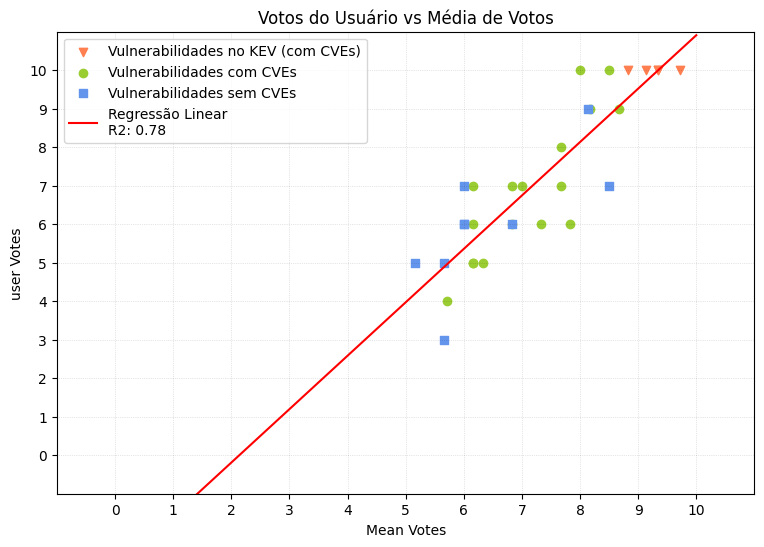

In [53]:
for user in num_users_df["user_id"].unique():
  html_data = {}
  
  df_user = df_vn[df_vn["user_id"] == user].copy()

  user_name = num_users_df[num_users_df["user_id"] == user]["Nome"].values[0].split()[0]
  user_mail = num_users_df[num_users_df["user_id"] == user]["email"].values[0]
  
  html_data["intern_name"] = user_name
  
  if df_user.empty:
    html_data["is_empty"] = True
    generate_html(html_data, filename=user_mail)
    continue
  
  #1 - Scatterplot with one point per vulnerability (x = average rank, y = intern’s rank)
  plot_votes_vs_mean(user, df_user, filename=user_mail)
  
  #3 - Sort rankings by time, then plot average error for each ranking (x = vulnerability ranking order by time; y = |rank(intern) - rank(average)|)
  # plot_rank_error_time_series(user, df_user, x_ticks=True)
  
  #2 - Get 3 vulnerabilities with the biggest difference between average and intern's rank
  html_data = generate_html_data(user, df_user, categorical=False)
  
  generate_html(html_data, filename=user_mail, categorical=False)
  
  del df_user
  

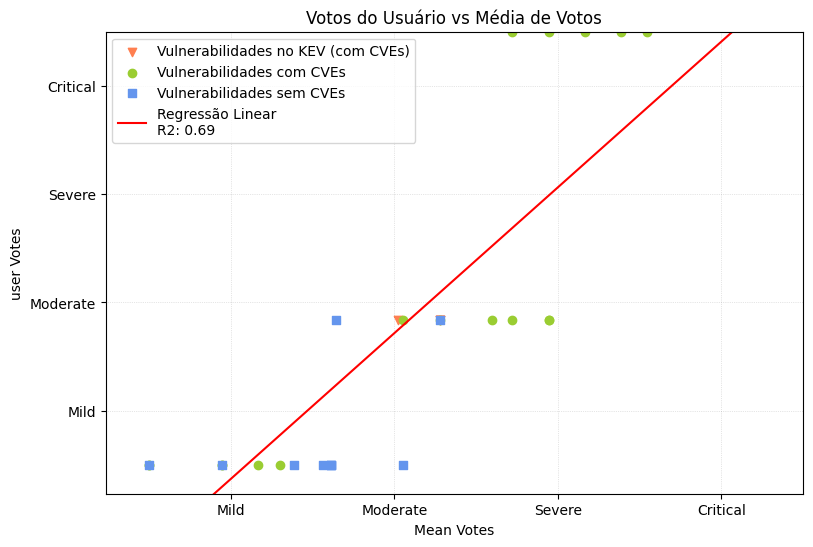

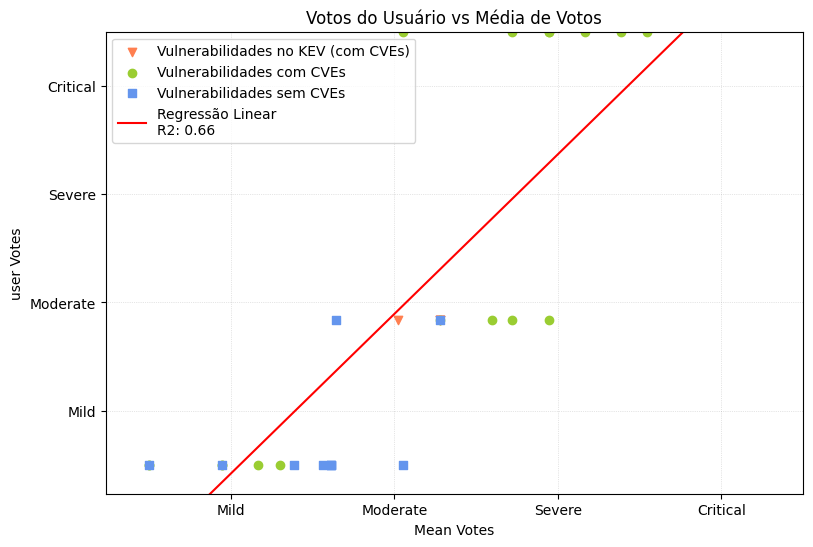

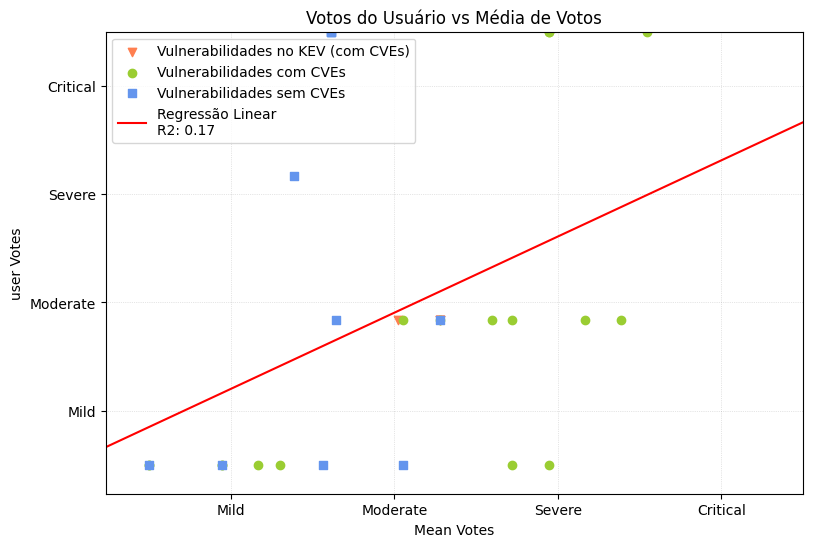

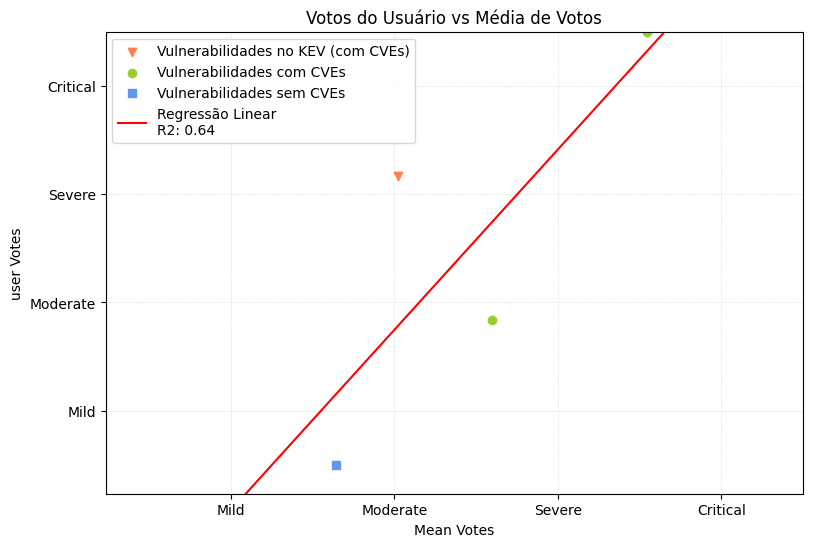

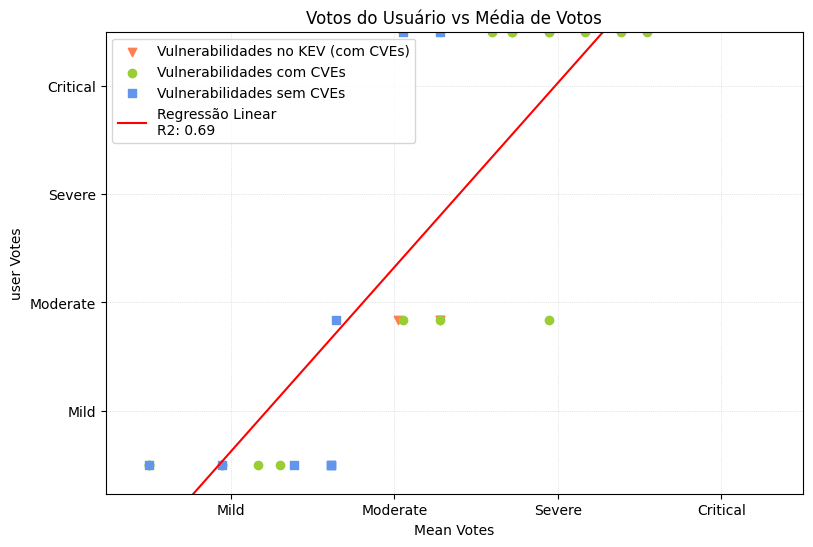

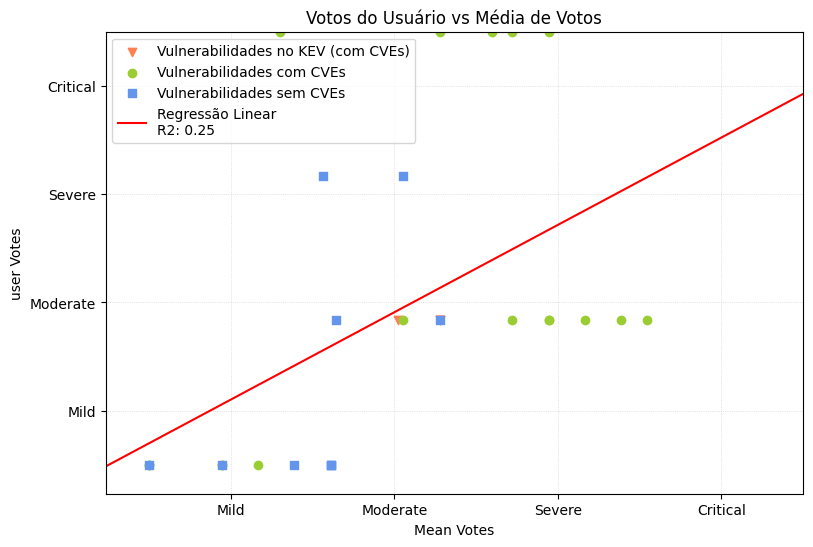

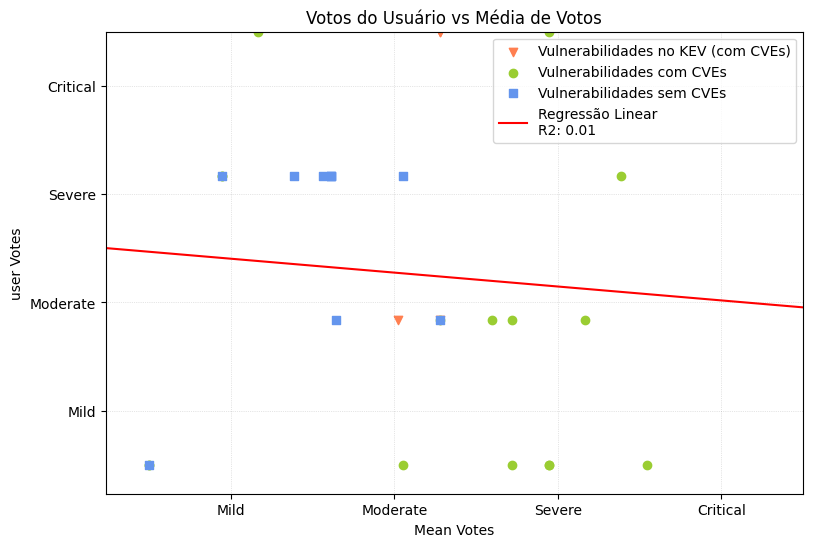

In [54]:
for user in cat_users_df["user_id"].unique():
  html_data = {}
  
  df_user = df_vc[df_vc["user_id"] == user].copy()

  user_name = cat_users_df[cat_users_df["user_id"] == user]["Nome"].values[0].split()[0]
  user_mail = cat_users_df[cat_users_df["user_id"] == user]["email"].values[0]
  
  html_data["intern_name"] = user_name
  
  if df_user.empty:
    html_data["is_empty"] = True
    generate_html(html_data, filename=user_mail)
    continue
  
  #1 - Scatterplot with one point per vulnerability (x = average rank, y = intern’s rank)
  plot_votes_vs_mean(user, df_user, categorical=True, filename=user_mail)
  
  #3 - Sort rankings by time, then plot average error for each ranking (x = vulnerability ranking order by time; y = |rank(intern) - rank(average)|)
  # plot_rank_error_time_series(user, df_user, x_ticks=True)
  
  #2 - Get 3 vulnerabilities with the biggest difference between average and intern's rank
  html_data = generate_html_data(user, df_user, categorical=True)
  
  generate_html(html_data, filename=user_mail, categorical=True)
  
  del df_user